In [1]:
# !pip install casadi

In [2]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

# Kinematics Hierarchy

Before we jump into solving the full MPC, it is important to know the mathematical model of the navigating agent which is described under two categories:

- **Kinematics**: Describes the motion of the robot based on geometry and velocities, without considering the forces that cause it

- **Dynamics**: Describes the motion by considering the masses, inertias, and forces/torques involved *(Ques-3 in A0: Cart-Pole)*


The complexity of a model is often determined by which derivative we control:

- **Position Control**: Directly setting $x, y$. (Rare in real robots)

- **First-Order (Single Integrator)**: We control Velocity ($\dot{x}$). The unicycle model is a non-holonomic single integrator. It is "non-holonomic" because the robot cannot move sideways; its velocity is constrained by its heading $\theta$.

- **Second-Order (Double Integrator)**: We control Acceleration ($\ddot{x}$). This accounts for the mass and inertia of the robot.

- **Third-Order**: We control Jerk ($\dddot{x}$), often used to ensure smooth trajectories for passenger comfort or mechanical longevity.

<hr>

By defining our model in these categories, we allow CasADi to 'unroll' the robot's future positions. Using the Kinematics, we map our control inputs ($u$) directly to the change in state ($\dot{x}$), allowing the optimizer to predict where the robot will be at every step of the horizon.

<hr>

## The Unicycle Model

For a unicycle, we control the linear velocity and the angular velocity.

- States ($x_{state}$):

    - $x$: X-position
    - $y$: Y-position
    - $\theta$: Heading angle

- Controls ($u$):

    - $v$: Linear velocity
    - $\omega$: Angular velocity
    
The equations of motion are:

$$\begin{aligned}
    \dot{x} &= v \cos(\theta) \\
    \dot{y} &= v \sin(\theta) \\
    \dot{\theta} &= \omega
\end{aligned}$$

To implement this in CasADi, we use the **Euler Integration method** to convert the continuous equations into a discrete form.

Given a sampling time $dt$, the state at the next time step $k+1$ is:

$$
\begin{aligned}
x_{k+1} &= x_k + v_k \cos(\theta_k) \Delta t \\
y_{k+1} &= y_k + v_k \sin(\theta_k) \Delta t \\
\theta_{k+1} &= \theta_k + \omega_k \Delta t
\end{aligned}
$$

**Projecting the Robot's Future:**

Using these recursive equations, we can identify the position of the robot at any future time step $k$. If we have an initial state $x_0$ and a sequence of $k$ velocity inputs $U = \{u_0, u_1, \dots, u_{k-1}\}$, the final position is a result of "unrolling" the dynamics:

$$x_n = x_0 + \sum_{k=0}^{n-1} f(x_k, u_k) \Delta t$$

<hr>

In an MPC context, CasADi treats this sequence as a chain of symbolic expressions. By adjusting the controls $u_0 \dots u_{k-1}$, the solver finds a path that obeys these physical laws while reaching the target.

<hr>

#### Parameters

In [3]:
N = 10  # Planning Horizon
dt = 0.1  # Time step

start = [0.0, 0.0, 0.0]
target = [10.0, 10.0, 0.0]

#### Unicycle Kinematics

In [4]:
x_sym = ca.SX.sym("x", 3)  # [x, y, theta]
u_sym = ca.SX.sym("u", 2)  # [v, omega]

rhs = ca.vertcat(u_sym[0] * ca.cos(x_sym[2]), u_sym[0] * ca.sin(x_sym[2]), u_sym[1])
print(f"RHS: {rhs}")

RHS: [(u_0*cos(x_2)), (u_0*sin(x_2)), u_1]


#### Prediction Step

We now have the continuous rate of change ($\dot{x}$). To predict where the robot will be at the next step, we need to "integrate" these equations.

The simplest method is Euler Integration:
$$x_{next} = x_{current} + \mathbf{\dot{x}} \cdot \Delta t$$

So, we need to write a symbolic function `f` that takes the current `states` and `controls` and returns the `next_states` using this Euler formula. (Assume a time step `dt = 0.1`).

In [5]:
# Euler Integration
x_next = x_sym + rhs * dt

# We need a reusable function for the kinematics to use inside the loop
unicycle = ca.Function("f", [x_sym, u_sym], [x_next])


In [6]:
# Test: If we are at [0,0,0] and move with v=1, omega=0 for 0.1s
res = unicycle([0,0,0], [1,0])
print(f"Next State: {res}")

Next State: [0.1, 0, 0]


## Build Optimization Problem

- Now we have a function `f` (unicyle) that predicts one step ahead. In MPC, we need to predict N steps ahead (the "Horizon").

- To do this, we need to create a variable for every state and every control at every time step.

- If our horizon is $N=10$:

    - How many control vectors $u$ do we need to find? -> 10
    - How many state vectors $x$ do we need to track? -> 11
    
**This determines the size of our optimization problem.**

<hr>

*(Since a few of you looked clueless during the session about why we have 11 states but 10 controls, hence elaborating)*

The state at the next time step is defined by a function of the current state and current control (in our case- unicycle kinematics):
$$x_{k+1} = f(x_k, u_k)$$

If you plug in your 10 control vectors ($u_0$ through $u_9$):

- Using $u_0$ takes you from $x_0 \to x_1$
- Using $u_1$ takes you from $x_1 \to x_2$...
- Using $u_9$ takes you from $x_9 \to x_{10}$

Without $x_{10}$, you wouldn't be able to define the result of your very last control action ($u_9$), and you wouldn't be able to set a Terminal Constraint (like "stop exactly at the red light").

<hr>

#### Defining Costs

$$
J = \underbrace{\sum_{k=0}^{N-1} \left( w_{stage} \| p_k - p_{target} \|^2 \right)}_{\text{Stage Cost } (x_0 \dots x_{N-1})}
+
\underbrace{w_{goal} \| p_N - p_{target} \|^2}_{\text{Terminal Cost } (x_N)}
$$

which is basically,

$$
J = \sum_{k=0}^{N-1} w_{stage} \left[ (x_k - 10)^2 + (y_k - 10)^2 \right] + w_{goal} \left[ (x_N - 10)^2 + (y_N - 10)^2 \right]
$$

- `dist_sq` inside loop: Corresponds to $\| p_{k} - p_{target} \|^2$
- `w_stage`: The weight applied to every step of the trajectory
- `w_goal_reaching`: The weight applied only to the final state $p_N$ to ensure the robot stops exactly at the target (usually needed in a complex step to avoid overshooting)

In [7]:
# Initialize
P = ca.SX.sym("P", 3)
curr_state = P  # x_0

w_stage = 1.0
w_goal_reaching = 10

U = []  # To hold control symbols
J = 0  # Cost function

# 1. Loop over the horizon steps (0 to N-1): Stage Cost
for k in range(N):
    # Define Control
    u_k = ca.SX.sym(f"U_{k}", 2)
    U.append(u_k)

    # Calculate cost for the current state (x_k)
    # This penalizes x0, x1, ... x(N-1)
    dist_sq = (curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2
    J += w_stage * dist_sq

    # You can also add control cost here (standard practice)
    # J += w_control * (u_k[0]**2 + u_k[1]**2)

    # Evolve (x_k -> x_{k+1})
    curr_state = unicycle(curr_state, u_k)

# 2. curr_state is now x_N. We now add Terminal Cost.
J += w_goal_reaching * ((curr_state[0] - target[0])**2 + (curr_state[1] - target[1])**2)

In [8]:
print(f"Control Vector (decision variable) \nU:{U}")

Control Vector (decision variable) 
U:[SX([U_0_0, U_0_1]), SX([U_1_0, U_1_1]), SX([U_2_0, U_2_1]), SX([U_3_0, U_3_1]), SX([U_4_0, U_4_1]), SX([U_5_0, U_5_1]), SX([U_6_0, U_6_1]), SX([U_7_0, U_7_1]), SX([U_8_0, U_8_1]), SX([U_9_0, U_9_1])]


#### Solver Setup

In [9]:
# Flatten the control list into one giant vector
OPT_variables = ca.vertcat(*U)

# Define the NLP
nlp_prob = {"f": J, "x": OPT_variables, "p": P}

opts = {"ipopt.print_level": 0, "print_time": False, "ipopt.tol": 1e-4}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, opts)

#### Bounds

In [10]:
# Control bounds: Physical limits of the robot
# NOTE: We need to create the numerical bound vectors that
# match the shape of the decision vector OPT_variables.
# Hence it is multiplied by N
lbx = [-5, -2] * N
ubx = [5, 2] * N

# Initial guess
u_guess = [0] * (N * 2)

In [11]:
print(lbx)

[-5, -2, -5, -2, -5, -2, -5, -2, -5, -2, -5, -2, -5, -2, -5, -2, -5, -2, -5, -2]


### Solve

We have defined our cost and constraints, now we need to provide an initial guess and solve.

Solvers like IPOPT need a starting point to begin their search. For this simple problem, starting with a guess of "all zeros" is sufficient.

In [12]:
sol = solver(x0=u_guess, lbx=lbx, ubx=ubx, p=start)

opt_u = sol["x"].full().flatten()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



#### Plot

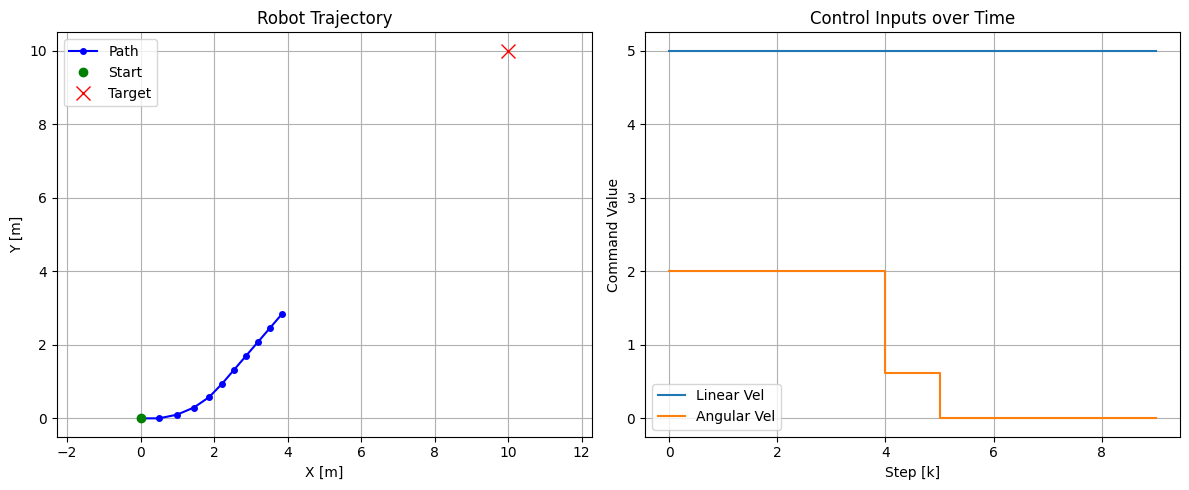

In [13]:
path_x = [start[0]]
path_y = [start[1]]
curr_state_ = np.array(start, dtype=np.float64)

v_cmds = opt_u[0::2]
w_cmds = opt_u[1::2]
time_steps = np.arange(N)

for k in range(N):
    v_k, w_k = v_cmds[k], w_cmds[k]
    theta = curr_state_[2]

    curr_state_[0] += v_k * np.cos(theta) * dt
    curr_state_[1] += v_k * np.sin(theta) * dt
    curr_state_[2] += w_k * dt

    path_x.append(curr_state_[0])
    path_y.append(curr_state_[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trajectory
ax1.plot(path_x, path_y, "b-o", markersize=4, label="Path")
ax1.plot(start[0], start[1], "go", label="Start")
ax1.plot(target[0], target[1], "rx", markersize=10, label="Target")
ax1.set_title("Robot Trajectory")
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.axis("equal")
ax1.grid(True)
ax1.legend()

# Controls
ax2.step(time_steps, v_cmds, where='post', label="Linear Vel")
ax2.step(time_steps, w_cmds, where='post', label="Angular Vel")
ax2.set_title("Control Inputs over Time")
ax2.set_xlabel("Step [k]")
ax2.set_ylabel("Command Value")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()